In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

parasitized_path = 'cell_images/Parasitized/'
healthy_path = 'cell_images/Healthy/'


In [3]:
def load_data_and_labels(folder_path, label):

    images = []
    labels = []

    for filename in os.listdir(folder_path):

        image = cv2.imread(os.path.join(folder_path,filename))

        if image is not None:
            image = cv2.resize(image, (64,64))
            images.append(image)
            labels.append(label)

    return images,labels

uninfected_images, uninfected_labels = load_data_and_labels(healthy_path,0)
parasitized_images, parasitized_labels = load_data_and_labels(parasitized_path,1)



X = np.array(uninfected_images + parasitized_images)
y = np.array(uninfected_labels + parasitized_labels)

X = X / 255.0
print(X.shape)
n_samples, height, width, n_channels = X.shape
X = X.reshape(n_samples, -1)


(27556, 64, 64, 3)


In [51]:
X.shape

(27556, 12288)

In [8]:
# Build my custom logistic regression model 

def sigmoid(z):
    y = 1 / (1 + np.exp(-z))
    return y

def binary_cross_entropy(y_true,y_pred):
    ce = -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
    return ce

def accuracy(y_true,y_pred):
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    acc = (correct / total) * 100

    return acc


def predict(X, W, b,threshold = .5):
    z = X.dot(W) + b
    probabilities = sigmoid(z)
    predictions = (probabilities >= threshold).astype(int)
    return probabilities, predictions


def train_logistic_regression(X_train,X_test,y_train,y_test,lr=0.001,epochs=10000):

    samples,features = X.shape

    W = np.zeros(features)
    b = 0

    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Predict for train and test sets
        y_train_pred_prob,y_train_pred = predict(X_train, W, b)
        y_test_pred_prob,y_test_pred = predict(X_test, W, b)

        # Calculate losses
        train_loss = binary_cross_entropy(y_train, y_train_pred_prob)
        test_loss = binary_cross_entropy(y_test, y_test_pred_prob)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_accuracy = accuracy(y_train,y_train_pred)
        test_accuracy = accuracy(y_test,y_test_pred)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}, Train accuracy: {train_accuracy}, Test accuracy: {test_accuracy}')


        dW = ((y_train_pred_prob - y_train).dot(X_train)) / samples
        db = (np.sum(y_train_pred_prob - y_train)) / samples

        

        W -= lr * dW
        b -= lr * db

    return W,b,train_losses,test_losses,train_accuracies,test_accuracies


X, y = shuffle(X, y, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=101)
final_W, final_b, train_losses, test_losses,train_accuracies,test_accuracies = train_logistic_regression(X_train,X_test,y_train,y_test)

Epoch: 0, Train Loss: 0.6931471805599453, Test Loss: 0.6931471805599454, Train accuracy: 50.08619125385593, Test accuracy: 49.65529753265602
Epoch: 100, Train Loss: 0.6712230569806156, Test Loss: 0.6710646692754424, Train accuracy: 62.13482126655779, Test accuracy: 63.08055152394775
Epoch: 200, Train Loss: 0.6601557230197194, Test Loss: 0.6603287917600822, Train accuracy: 62.57938668118309, Test accuracy: 63.588534107402026
Epoch: 300, Train Loss: 0.6529763997619962, Test Loss: 0.6536247046141773, Train accuracy: 63.110143349664305, Test accuracy: 63.73367198838898
Epoch: 400, Train Loss: 0.6475394209048364, Test Loss: 0.6487147958695813, Train accuracy: 63.386862638359645, Test accuracy: 63.951378809869375
Epoch: 500, Train Loss: 0.6430781896399999, Test Loss: 0.6447842195307874, Train accuracy: 63.74977318091091, Test accuracy: 64.27793904208998
Epoch: 600, Train Loss: 0.6392725127345271, Test Loss: 0.641489328945335, Train accuracy: 64.02195608782435, Test accuracy: 64.5863570391872

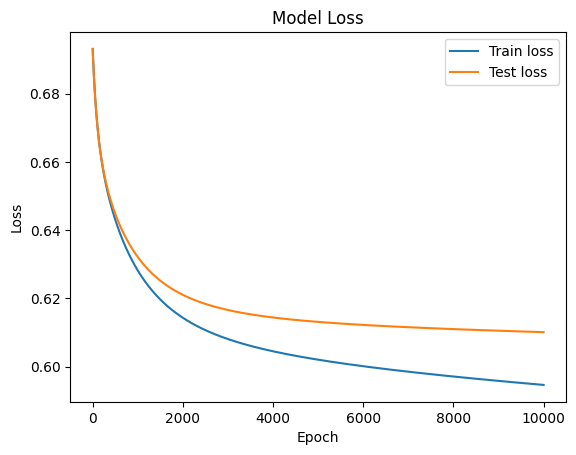

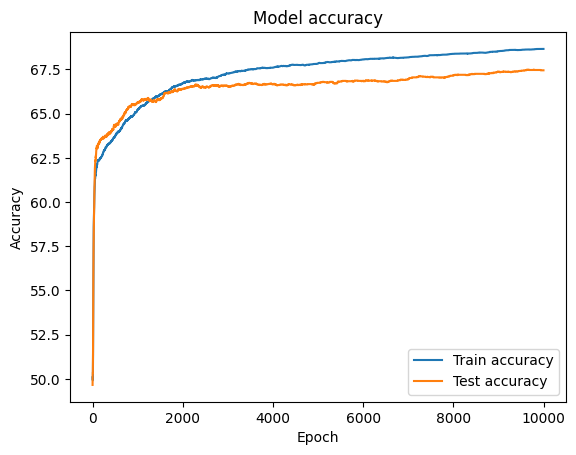

In [9]:
plt.plot(train_losses,label='Train loss')
plt.plot(test_losses,label='Test loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


plt.plot(train_accuracies,label='Train accuracy')
plt.plot(test_accuracies,label='Test accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [32]:
def predict_with_trained_model(bestW,bestb,X):
    probabilities = sigmoid(X.dot(bestW) + bestb)
    predictions = (probabilities >= 0.5).astype(int)  
    return predictions


y_test_pred = predict_with_trained_model(final_W,final_b,X_test)

def accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    correct_predictions = np.sum(y_true == y_pred)
    
    acc = correct_predictions / len(y_true)
    return acc

def recall(y_true, y_pred):

    # Ensure both arrays are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # True Positives (TP): Both true label and prediction are 1
    tp = np.sum((y_true == 1) & (y_pred == 1))
    
    # False Negatives (FN): True label is 1, but prediction is 0
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate recall
    recall_score = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return recall_score


accuracy(y_test,y_test_pred)






np.float64(0.6897677793904209)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming X and y are your dataset and labels
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)  # Binary class predictions
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Optional: Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation Metrics:
Accuracy: 67.58%
Precision: 69.60%
Recall: 64.99%
F1 Score: 67.22%

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      2693
           1       0.70      0.65      0.67      2819

    accuracy                           0.68      5512
   macro avg       0.68      0.68      0.68      5512
weighted avg       0.68      0.68      0.68      5512



/Users/ktsolakidis/miniconda3/envs/ML/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# Assume X and y are your dataset and labels
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the Feed-Forward Neural Network
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, 
                    batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict probabilities and binary labels
y_pred_prob = model.predict(X_test)  # Probabilities
y_pred = (y_pred_prob >= 0.5).astype(int)  # Binary labels


/Users/ktsolakidis/miniconda3/envs/ML/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5505 - loss: 1.9324 - val_accuracy: 0.6179 - val_loss: 0.6623
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5650 - loss: 0.7290 - val_accuracy: 0.6533 - val_loss: 0.6406
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5862 - loss: 0.6753 - val_accuracy: 0.6602 - val_loss: 0.6409
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6036 - loss: 0.6613 - val_accuracy: 0.6771 - val_loss: 0.6235
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6231 - loss: 0.6419 - val_accuracy: 0.6836 - val_loss: 0.6153
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6246 - loss: 0.6450 - val_accuracy: 0.6889 - val_loss: 0.6012
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6435 - loss: 0.6258 - val_accuracy: 0.6889 - val_loss: 0.5978
Epoch 8/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6484 - loss: 0.6159 - val_accu

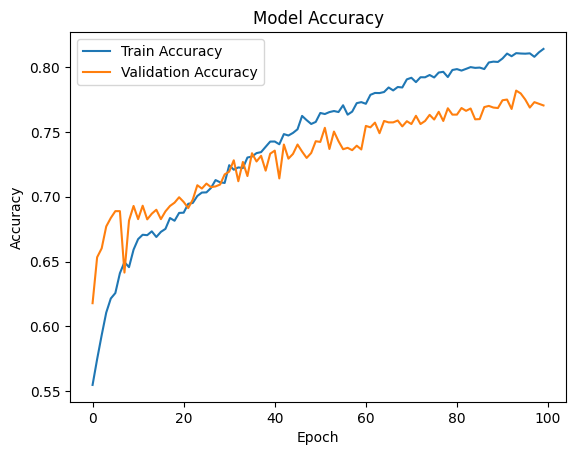

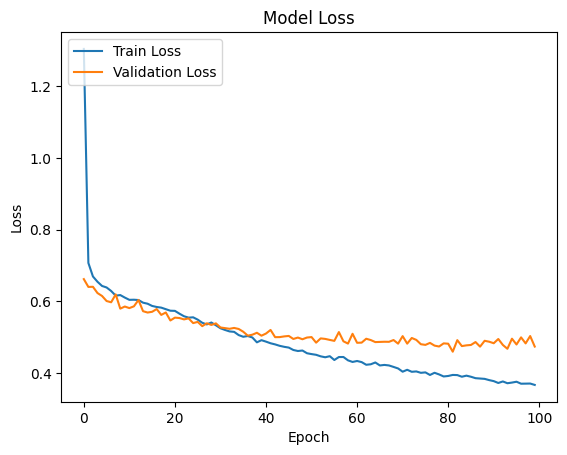

In [79]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


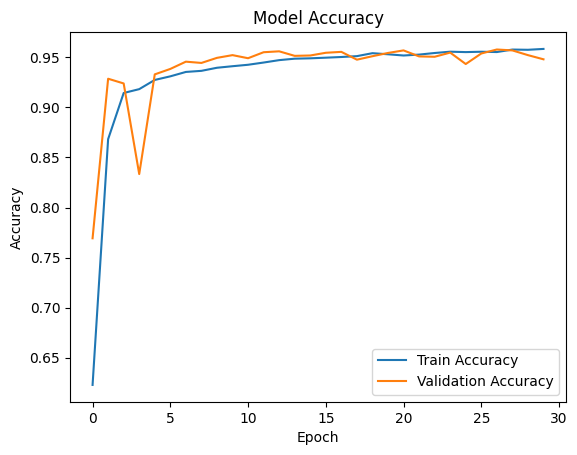

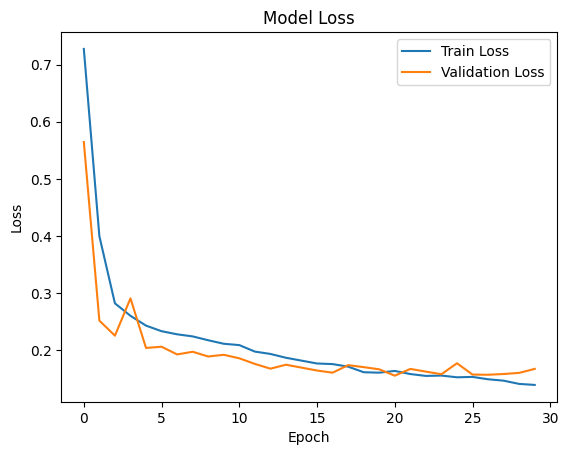

In [71]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [86]:
from tensorflow.keras.utils import plot_model

# Assuming your model is defined as `model`
plot_model(model, to_file='modejbl.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.
